# Predizione Prezzo Bitcoin
## Autori: Luca Morlino e Valerio Di Zio


In [244]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

## Descrizione del problema
### Cos'è Bitcoin?
Il Bitcoin è una moneta virtuale creata nel 2009 da uno o più utenti con lo pseudonimo Satoshi Nakamoto. Diversamente dalle altre valute il Bitcoin non ha dietro una Banca centrale che distribuisce nuova moneta ma si basa fondamentalmente su due principi: un network di nodi, cioè di pc, che la gestiscono in modalità distribuita, peer-to-peer; e l'uso di una forte crittografia per validare e rendere sicure le transazioni.
### Obiettivo
L'obiettivo generale è quello di creare un algoritmo che preveda il valore di chiusura di bitcoin a inizio giornata.
Il bitcoin essendo una valuta a tutti gli effetti non ha un orario di apertura né uno di chiusura, per comodità il nostro dataset considera il valore di apertura a mezzanotte e il valore di chiusura a mezzanotte del giorno dopo.

## Estrazione dati
I dati relativi a BTC vengono scaricati dal servizio [Yahoo! Finance](https://it.finance.yahoo.com/).
Per fare ciò viene utilizzata la libreria yfinance che permette l'estrazione di dati in forma di oggetti Python facilmente interrogabili.
In particolare, la usiamo per ottenere i dati storici in forma di Dataframe Pandas

In [245]:
import yfinance

- Creiamo un oggetto Ticker che rappresenta uno specifico titolo o indice
- Nel nostro caso il simbolo del Bitcoin con il suo valore in Euro è BTC-EUR

In [246]:
btc = yfinance.Ticker("BTC-EUR")

- Utilizziamo il metodo history per ottenere i dati storici, partendo dal 1 gennaio 2015 fino a ieri.

In [247]:
from datetime import date

In [248]:
today = date.today().strftime("%Y-%m-%d")
data = btc.history(start="2019-01-01", end=today, actions=False)

Ad esempio, guardiamo i dati relativi agli ultimi 5 giorni. 

Ovviamente i dati odierni non sono presenti, saranno quelli che andremo a prevedere.

In [249]:
data.tail(5)

,Open,High,Low,Close,Volume
Date,,,,,
2022-06-11,27648.988281,27950.578125,26840.496094,26958.935547,25899776264
2022-06-12,26971.011719,27093.796875,25513.984375,25513.984375,32569266905
2022-06-13,25490.082031,25545.843750,21262.470703,21592.951172,65491720208
2022-06-14,21593.527344,22084.058594,20144.820312,21274.751953,48776681576
2022-06-15,21265.111328,21666.794922,19254.548828,21586.835938,52513395637



Andiamo a contare il numero di istanze ricavate

In [250]:
data.shape[0]

1263

## Features
Il nostro dataset ha 5 features:
- Open: è il valore in euro di un singolo bitcoin all'orario di apertura
- High: è il valore massimo in euro raggiunto durante la giornata
- Low: è il valore minimo in euro raggiunto durante la giornata
- Close: è il valore in euro di un singolo bitcoin all'orario di chiusura
- Volume: il volume di trading indica (nel nostro caso) il valore in euro di bitcoin scambiati durante la giornata

Per comodità estraiamo una serie per ciascuna colonna, per potersi riferire ad esse con un unico nome.

In [251]:
open = data["Open"]
high = data["High"]
low = data["Low"]
close = data["Close"]
volume = data["Volume"]

## Rappresentazione dei dati

Possiamo tracciare il grafico dell'andamento del prezzo, basandoci sulla feature "Open".

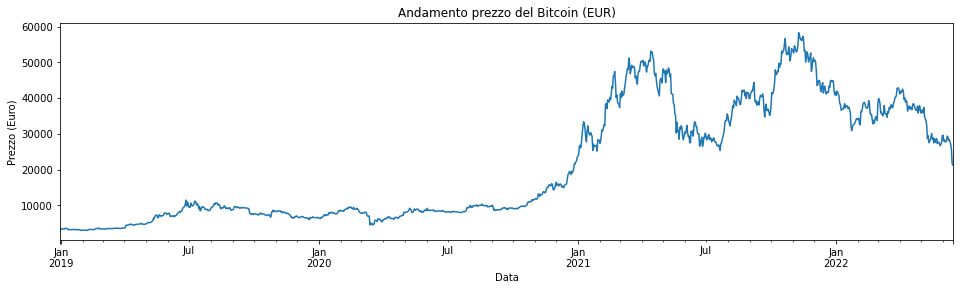

In [252]:
open.plot(figsize=(16,4))
plt.title("Andamento prezzo del Bitcoin (EUR)")
plt.xlabel("Data")
plt.ylabel("Prezzo (Euro)");

Utilizzando la libreria plotly è possibile visualizzare in un unico grafico 4 features (Open, High, Low, Close)

In [253]:
import plotly.graph_objects as go

In [254]:
candlestick = go.Candlestick(
                            x=data.index,
                            open=data['Open'],
                            high=data['High'],
                            low=data['Low'],
                            close=data['Close']
                            )


Il grafico è rappresentato mediante l'utilizzo di Candele, queste ultime rappresentano l'andamento del prezzo di una giornata.

<img src="candlestick.jpeg" alt="Candlestick" style="width:700px;"/>


In [255]:
from ipywidgets.widgets import interact
from datetime import timedelta

Ricaviamo la data relativa a 50 giorni fa

In [256]:
DD = timedelta(days=50)
earlier = date.today() - DD
earlier_str = earlier.strftime("%Y-%m-%d")

In [257]:


@interact(ymin=(0,60000,1000), ymax=(0,50000,1000))
def plot_candlestick(ymin=20000, ymax=40000):    
    fig = go.Figure(data=[candlestick])
    fig.update_layout(
        width=1000, height=700,
        title="Andamento prezzo Bitcoin Candlestick",
        yaxis_title='Prezzo (EURO)'
    )
    fig.update_xaxes(type="date", range=[earlier_str, today])
    fig.update_yaxes(range=[ymin,ymax])
    fig.show()

interactive(children=(IntSlider(value=20000, description='ymin', max=60000, step=1000), IntSlider(value=40000,…

Mostriamo ora alcune statistiche generali raggruppate per anno come:
- Media
- Deviazione Standard
- Min e Max
- Quartili


In [258]:
hlm = (high + low) / 2
hlm.groupby(hlm.index.year).describe()

,count,mean,std,min,25%,50%,75%,max
Date,,,,,,,,
2018,1.0,3304.445435,NaN,3304.445435,3304.445435,3304.445435,3304.445435,3304.445435
2019,365.0,6611.505284,2378.373599,3008.023071,4043.200562,6979.854004,8610.137695,11237.593750
2020,366.0,9604.105389,3304.767447,4463.527954,8029.480408,8710.522217,9805.435303,23380.625977
2021,365.0,40095.692624,8737.824810,23983.438477,31245.380859,40675.902344,47296.929688,58211.095703
2022,166.0,34909.115805,4678.943329,20460.671875,32376.854248,36507.617188,37768.202148,43156.531250


## Prevedere il valore di chiusura a inizio giornata

La variabile da predire è la features "Close" relativa alla data odierna.

In [259]:
y = close

`high`, `low`, `volume` non possono essere utilizzate in quanto il loro valore non è noto a inizio giornata.
Attualmente l'unica feature utilizzabile è il valore `open`.

In [260]:
features = {"Open" : open}
X = pd.DataFrame(features)

Suddividiamo i dati in un training set e in un validation set con la funzione `train_test_split`.

In [261]:
TEST_SIZE = 0.4

In [262]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, shuffle=False)

## Test 1: Regressione Lineare

Usandro training e validation set creati in precedenza addestriamo un modello di regressione lineare e calcoliamo R<sup>2</sup>.

In [263]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)
model.score(X_val, y_val)

0.964586835942706

In [264]:
model = Pipeline([
    ("poly", PolynomialFeatures(degree=5, include_bias=False)),
    ("regr", Ridge(alpha=1))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

/Users/valerio/miniforge3/envs/di/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning:

Ill-conditioned matrix (rcond=4.86788e-40): result may not be accurate.



0.635647867080178

In [265]:
model = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("scale", StandardScaler()),
    ("regr", LinearRegression())
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.41688457791277556

Il punteggio R<sup>2</sup> del modello risulta molto alto. Questo è dovuto al fatto che i valore `Open` e `Close` sono molto correlati.

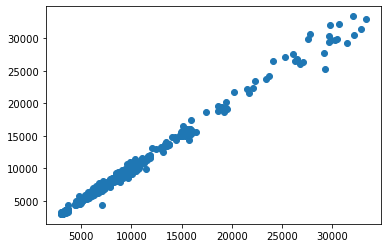

In [266]:
plt.scatter(X_train,y_train);

Per avere un riscontro dell'effetiva efficienza del modello calcoliamo il guadagno effettivo di un possibile investitore.

Per far ciò implementiamo un protocollo di trading che dati i valori di chiusura reali e predetti restituisce il guadagno effettivo.

**La cifra investita in questo caso è pari al valore di apertura che varia giornalmente**.

Definiamo la variabile differenza $\Delta_d=C_d-O_d$ tra il valore di chiusura giornaliero $C_d$ e di apertura $O_d$

In [267]:
delta = close - open

- Poniamo questo come il valore che **deve essere predetto** dal modello
- L'investitore agirà in base alla predizione $\hat{\Delta}_d$ in modo analogo a prima
  - se $\hat{\Delta}_d > 0$, acquista un titolo a inizio giornata e lo rivende alla fine
  - se $\hat{\Delta}_d < 0$, vende un titolo a inizio giornata e lo ricompra alla fine

### Importiamo alcune funzioni utili 

Possiamo definire una metrica "guadagno" per validare il modello, che restituisca il guadagno totale di un investitore che opera nel periodo a cui si riferisce il validation set

In [268]:
from utility import gain

Il ROI (Return on investiment) esprime il guadagno di una o più operazioni in borsa in rapporto all'investimento iniziale.

In [269]:
from utility import roi

Definiamo anche una funzione che stampi le metriche di valutazione del modello.

In [270]:
from utility import print_eval

La funzione `prepare_data` restituisce un Dataframe con le colonne indicate e una serie con i valori della variabile da predire corrispondenti alle righe selezionate del Dataframe.

In [271]:
from utility import prepare_data

Addestriamo ora invece un modello di regressione lineare prevedendo il delta e calcoliamo il `gain` e il `ROI`.

In [272]:
X, y = prepare_data(features, delta)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, shuffle=False)
model = LinearRegression()
model.fit(X_train, y_train)
print_eval(X_val, y_val, model, open)

Gain: -9155.65€
 ROI: -23.453%


Il risultato non è per nulla soddisfacente.

In [273]:
from utility import plot_model_on_data

/Users/valerio/miniforge3/envs/di/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



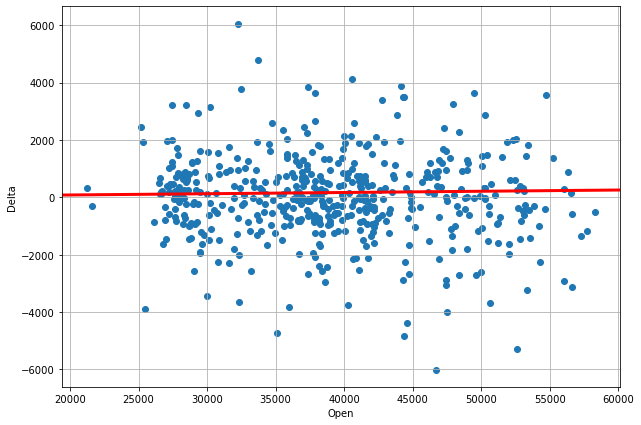

In [274]:
plot_model_on_data(X_val,y_val,model)

## Nuove Features
Andiamo ora ad introdurre nuove features: possiamo integrare informazioni note dai giorni precedenti ad ogni singola giornata.

Possiamo usare `shift` per generare le variabili che si riferiscono ai dati dei giorni precenti.

In [275]:
features = {
    "Open": open,
    "OpenShift1": open.shift(1),
    "OpenShift2": open.shift(2),
    "OpenShift3": open.shift(3),
    "OpenShift4": open.shift(4),
}

Andiamo ora a testare il modello con le nuove features.

In [276]:
X, y = prepare_data(features, delta)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, shuffle=False)
model = LinearRegression()
model.fit(X_train, y_train)
print_eval(X_val, y_val, model, open)

Gain: -8975.55€
 ROI: -22.962%


Si noti come nonostante l'aggiunta di features il modello non crea profitto, ma una perdita.

Andiamo quindi ad aggiungere features diverse.

- Exponential Moving Average, si tratta di una media mobile che si muove in seguito a variazioni di prezzo: raccoglie i dati generati nell'ultima sessione scartando i dati più vecchi della serie temporale. Quindi l'EMA risponde più rapidamente alle recenti variazioni di prezzo.

In [277]:
def calculate_ema(prices, days, smoothing=2):
    ema = [sum(prices[:days]) / days]
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
    return ema


ema = calculate_ema(data['Open'], 10) # Add this line to save EMA values in a list

In [278]:
ema = pd.Series(data=ema, index=data[9:].index)
data["EMA"] = ema

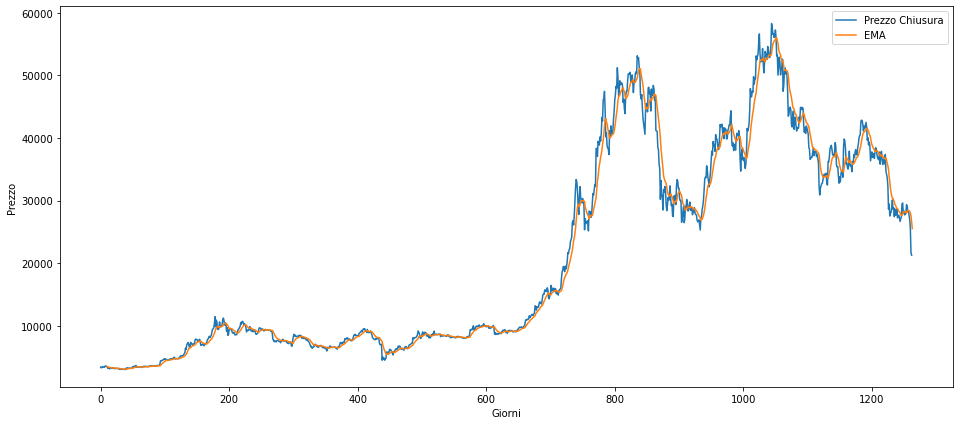

In [279]:
price_X = np.arange(data.shape[0])
ema_X = np.arange(10, data.shape[0]+1)
plt.figure(figsize=(16, 7))
plt.xlabel('Giorni')
plt.ylabel('Prezzo')
plt.plot(price_X, data['Open'], label='Prezzo Chiusura')
plt.plot(ema_X, ema, label='EMA')
plt.legend()
plt.show()

In [280]:
features={
    "Open": open,
    "OpenShift1": open.shift(1),
    "OpenShift2": open.shift(2),
    "OpenShift3": open.shift(3),
    "OpenShift4": open.shift(4),
    "EMA": data["EMA"]
}

In [281]:
X, y = prepare_data(features, delta)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, shuffle=False)
model = LinearRegression()
model.fit(X_train, y_train)
print_eval(X_val, y_val, model, open)

Gain: -54989.88€
 ROI: -140.506%


Anche con l'aggiunta della feature EMA non si ottiene un buon risultato, questo è dovuto alla scarsa adattabilità della Regressione Lineare.

In [282]:
# TO DELETE, usato per testare giornaliero
d = {"Open":[21586.84], "OpenShift1":[21265.11], "OpenShift2":[21593.53], "OpenShift3":[25490.08], "OpenShift4":[26971.01], "EMA":[24809.78]}
model.predict(pd.DataFrame(d))

array([231.62629201])

Aggiungiamo al nostro dataset MACD: Moving Average Convergence Divergence.
- Come suggerisce il nome, l'indicatore valuta due medie mobili e la relazione tra loro.

In [283]:
def computeMACD (df, n_fast, n_slow, n_smooth):
    data = df['Open']
    
    fastEMA = data.ewm(span=n_fast, min_periods=n_slow).mean()
    slowEMA = data.ewm(span=n_slow, min_periods=n_slow).mean()
    MACD = pd.Series(fastEMA-slowEMA, name = 'MACD')
    #MACDsig = pd.Series(MACD.ewm(span=n_smooth, min_periods=n_smooth).mean(), name='MACDsig')
    #MACDhist = pd.Series(MACD - MACDsig, name = 'MACDhist')
    df = df.join(MACD)
    #df = df.join(MACDsig)
    #df = df.join(MACDhist)
    
    return df

In [284]:
data = computeMACD(data, 12, 26, 9)

In [311]:
features={
    "Open": open,
    "OpenShift1": open.shift(1),
    "OpenShift2": open.shift(2),
    "OpenShift3": open.shift(3),
    "OpenShift4": open.shift(4),
    "EMA": data["EMA"],
    "MACD": data["MACD"],
}

In [312]:
X, y = prepare_data(features, delta)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, shuffle=False)
model = LinearRegression()
model.fit(X_train, y_train)
print_eval(X_val, y_val, model, open)

Gain: -12861.09€
 ROI: -32.756%


È possibile notare come l'aggiunta di nuove features permette di avere una perdita sempre minore, sfortunatamente la limitazione della Regressione Lineare non permette di ottenere risultati tanto migliori, quindi valutiamo altri metodi.

Continuiamo ad aggiungere features utili alla predizione del valore di chiusura.

## Test 2: XGBoost

In [313]:
import xgboost
from xgboost import XGBRegressor

/Users/valerio/miniforge3/envs/di/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [319]:
xgbm = XGBRegressor(objective='reg:squarederror', learning_rate = 0.01577, reg_lambda=0.008, reg_alpha=0.0001, n_estimators=1025, verbose_eval=False)
xgbm.fit(X_train, y_train)
print_eval(X_val, y_val, xgbm, open)

[17:30:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:576: 
Parameters: { "verbose_eval" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Gain: 8627.67€
 ROI: 21.974%
